## Implementation of LSTM model on Energy Consumption Data

### Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Series
from matplotlib import pyplot
import time
import math
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
%matplotlib inline

### Reading the data

In [3]:
df = pd.read_csv("/home/rohan/CMI/SEM_2/AML/AML2/EKPC_hourly.csv")
df.head()

,Datetime,EKPC_MW
0,2013-06-01 01:00:00,1166.0
1,2013-06-01 02:00:00,1098.0
2,2013-06-01 03:00:00,1036.0
3,2013-06-01 04:00:00,1023.0
4,2013-06-01 05:00:00,949.0


In [4]:
#Dropping datetime column and keeping only the energy consumption values
data=df.drop(['Datetime'],axis=1)
df.head()
data.head()

,Datetime,EKPC_MW
0,2013-06-01 01:00:00,1166.0
1,2013-06-01 02:00:00,1098.0
2,2013-06-01 03:00:00,1036.0
3,2013-06-01 04:00:00,1023.0
4,2013-06-01 05:00:00,949.0


,EKPC_MW
0,1166.0
1,1098.0
2,1036.0
3,1023.0
4,949.0


### Visualizing the data

<Figure size 1080x360 with 0 Axes>

Text(0.5, 0, 'Time Point')

Text(0, 0.5, 'Hourly Energy Consumption')

Text(0.5, 1.0, 'Hourly Energy Consumption')

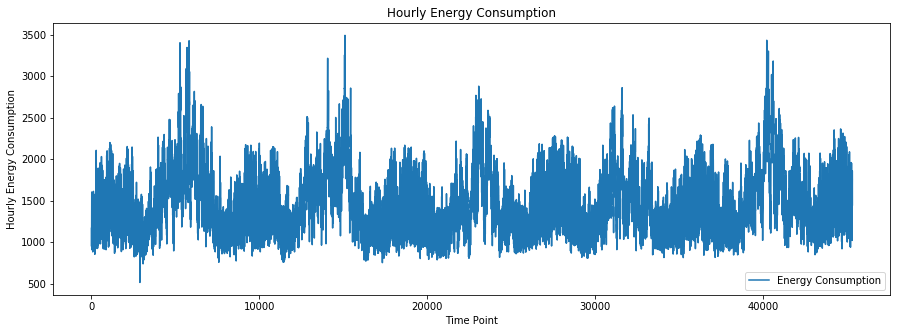

In [5]:
plt.figure(figsize = (15, 5))
plt.plot(data, label = "Energy Consumption")
plt.xlabel("Time Point")
plt.ylabel("Hourly Energy Consumption")
plt.title("Hourly Energy Consumption")
plt.legend()
plt.show()

#### Importing necessary libraries
</br> (For implementing LSTM)

In [6]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

Using TensorFlow backend.


In [7]:
data_raw = data.values.astype("float32")

# We apply the MinMax scaler from sklearn
# to normalize data in the (0, 1) interval.
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(data_raw)

# Print a few values.
dataset[0:5]

array([[0.21908604],
       [0.19623657],
       [0.17540322],
       [0.17103495],
       [0.14616935]], dtype=float32)

### Train-Test Split

In [8]:
TRAIN_SIZE = 0.70

train_size = int(len(dataset) * TRAIN_SIZE)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Number of entries (training set, test set): " + str((len(train), len(test))))

Number of entries (training set, test set): (31733, 13601)


### Implementation

In [9]:
def create_dataset(dataset, window_size = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + window_size, 0])
    return(np.array(data_X), np.array(data_Y))

In [10]:
window_size = 1
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
print("Original training data shape:")
print(train_X.shape)

# Reshape the input data into appropriate form for Keras.
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
print("New training data shape:")
print(train_X.shape)

Original training data shape:
(31731, 1)
New training data shape:
(31731, 1, 1)


### Fitting LSTM model

We can vary the parameters of the model. We tried different values for the parameters (layers,no of nodes in a layer etc). The result didn't change significantly. Here we show the result for a particular combination of the parameters.

In [11]:
def fit_model(train_X, train_Y, window_size = 1):
    model = Sequential()
    
    model.add(LSTM(3, 
                   input_shape = (1, window_size)))
    model.add(Dense(1))
    model.compile(loss = "mean_squared_error", 
                  optimizer = "adam")
    model.fit(train_X, 
              train_Y, 
              epochs = 5, 
              batch_size = 1, 
              verbose = 2)
    
    return(model)


In [12]:
model1 = fit_model(train_X, train_Y, window_size)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
 - 79s - loss: 0.0013
Epoch 2/5
 - 76s - loss: 7.0801e-04
Epoch 3/5
 - 75s - loss: 7.0485e-04
Epoch 4/5
 - 75s - loss: 7.0436e-04
Epoch 5/5
 - 76s - loss: 7.0356e-04


**RMSE score**

In [13]:
def predict_and_score(model, X, Y):
    # Make predictions on the original scale of the data.
    pred = scaler.inverse_transform(model.predict(X))
    # Prepare Y data to also be on the original scale for interpretability.
    orig_data = scaler.inverse_transform([Y])
    # Calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)

rmse_train, train_predict = predict_and_score(model1, train_X, train_Y)
rmse_test, test_predict = predict_and_score(model1, test_X, test_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)

Training data score: 76.86 RMSE
Test data score: 76.29 RMSE


### Visualizing the actual data and the prediction on the data

<Figure size 1080x360 with 0 Axes>

Text(0.5, 0, 'Months')

Text(0, 0.5, '1000 International Airline Passengers')

Text(0.5, 1.0, 'Comparison true vs. predicted training / test')

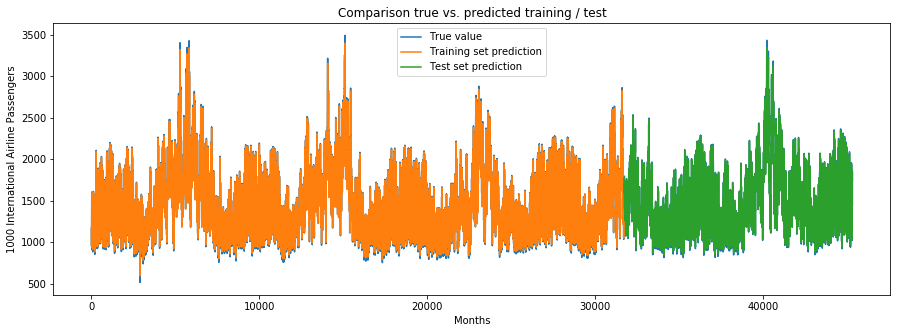

In [14]:
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[window_size:len(train_predict) + window_size, :] = train_predict

# Add test predictions.
test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict

# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(scaler.inverse_transform(dataset), label = "True value")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.xlabel("Months")
plt.ylabel("1000 International Airline Passengers")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
plt.show()


**Comment**: LSTM model fitted extremely well. Earlier we saw that the ARIMA fitted very badly and Fbprophet worked comparatively than the ARIMA model. But LSTM worked way better than the other. Based on this LSTM model we can get the predictions for any required period.